## Paths

In [2]:
dataset_path = "/home/juliamatos/Área de Trabalho/trabalhoCNN/datasets/SimpleSoyNet"
tensorboard_path = "../logs/"
models_path = "../models/SoyNet/"

## Dataloader

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [4]:
# carrega a ResNet do PyTorch
import torch
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2


# transformações para a ResNet18 
my_transform = MobileNet_V2_Weights.DEFAULT.transforms()


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


# função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [6]:
import torch
from torchvision.datasets import ImageFolder


# carrega o dataset de imagens com as transformações definidas
data = ImageFolder(root=dataset_path, transform=my_transform)

# divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 512

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

7299
5109
2190


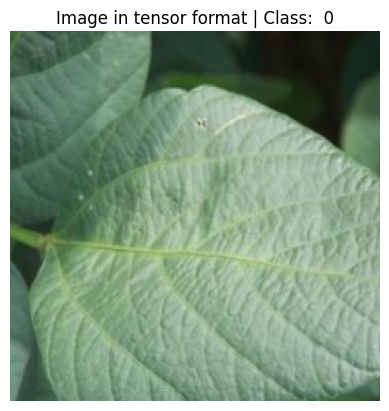

In [7]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

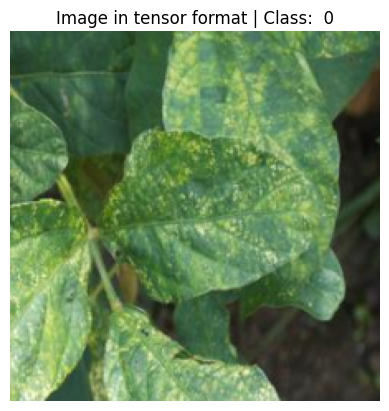

In [8]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

## Train

In [9]:
# função de validação do modelo
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

In [10]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy
def plot_layers(net, writer, epoch):
    # plot da camada fc (fully connected)
    if hasattr(net, "fc"):
        layer = net.fc
        if isinstance(layer, torch.nn.Linear):
            writer.add_histogram('Weight/fc', layer.weight, epoch)
            if layer.bias is not None:
                writer.add_histogram('Bias/fc', layer.bias, epoch)



def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    # otimizador e função de perda
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  
    
    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    

    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            
            train_x = train_x.to(device)
            train_label = train_label.to(device)

        
            predict_y = net( train_x )
            
            # loss
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # backpropagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "SoyNet"
        path = f'{models_path}ResNet18-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

## Run with ResNet18

In [11]:
# carrega a resnet18 pré-treinada com ImageNet
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/juliamatos/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 10.5MB/s]


In [12]:
# verifica as camadas do modelo
for name, param in model.named_parameters():
    print(f"{name}")

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.3.conv.0.0.weight
features.3.conv.0.1.weight
features.3.conv.0.1.bias
features.3.conv.1.0.weight
features.3.conv.1.1.weight
features.3.conv.1.1.bias
features.3.conv.2.weight
features.3.conv.3.weight
features.3.conv.3.bias
features.4.conv.0.0.weight
features.4.conv.0.1.weight
features.4.conv.0.1.bias
features.4.conv.1.0.weight
features.4.conv.1.1.weight
features.4.conv.1.1.bias
features.4.conv.2.weight
features.4.conv.3.weight
features.4.conv.3.bias
features.5.conv.0.0.weight
features.5.conv.0.1.weight
features.5.conv.0.1.bias
features.5.conv.1.

In [18]:
# congelar todos os parâmetros
for param in model.parameters():
    param.requires_grad = False

# liberar a última camada classifier
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
        print(f"Descongelando {name}")

# ajustar última camada para número de classes
num_classes = 2
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

Descongelando classifier.1.weight
Descongelando classifier.1.bias


In [19]:
# verifica as camadas que estão congeladas
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

features.0.0.weight: Frozen
features.0.1.weight: Frozen
features.0.1.bias: Frozen
features.1.conv.0.0.weight: Frozen
features.1.conv.0.1.weight: Frozen
features.1.conv.0.1.bias: Frozen
features.1.conv.1.weight: Frozen
features.1.conv.2.weight: Frozen
features.1.conv.2.bias: Frozen
features.2.conv.0.0.weight: Frozen
features.2.conv.0.1.weight: Frozen
features.2.conv.0.1.bias: Frozen
features.2.conv.1.0.weight: Frozen
features.2.conv.1.1.weight: Frozen
features.2.conv.1.1.bias: Frozen
features.2.conv.2.weight: Frozen
features.2.conv.3.weight: Frozen
features.2.conv.3.bias: Frozen
features.3.conv.0.0.weight: Frozen
features.3.conv.0.1.weight: Frozen
features.3.conv.0.1.bias: Frozen
features.3.conv.1.0.weight: Frozen
features.3.conv.1.1.weight: Frozen
features.3.conv.1.1.bias: Frozen
features.3.conv.2.weight: Frozen
features.3.conv.3.weight: Frozen
features.3.conv.3.bias: Frozen
features.4.conv.0.0.weight: Frozen
features.4.conv.0.1.weight: Frozen
features.4.conv.0.1.bias: Frozen
features.

Running on cuda


Training epochs...:   0%|          | 0/100 [00:00<?, ?it/s]

Training epochs...:   1%|          | 1/100 [00:58<1:36:01, 58.19s/it]

Saving Best Model with Accuracy:  86.57534246575342
Epoch:   1 | Accuracy : 86.5753%


Training epochs...:   2%|▏         | 2/100 [01:08<49:23, 30.23s/it]  

Epoch:   2 | Accuracy : 86.5753%


Training epochs...:   3%|▎         | 3/100 [01:20<35:19, 21.85s/it]

Epoch:   3 | Accuracy : 86.5753%


Training epochs...:   4%|▍         | 4/100 [01:31<28:05, 17.55s/it]

Epoch:   4 | Accuracy : 86.5753%


Training epochs...:   5%|▌         | 5/100 [01:42<24:08, 15.25s/it]

Epoch:   5 | Accuracy : 86.5753%


Training epochs...:   6%|▌         | 6/100 [01:53<21:27, 13.70s/it]

Epoch:   6 | Accuracy : 86.5753%


Training epochs...:   7%|▋         | 7/100 [02:04<20:01, 12.92s/it]

Epoch:   7 | Accuracy : 86.5753%


Training epochs...:   8%|▊         | 8/100 [02:16<19:09, 12.49s/it]

Epoch:   8 | Accuracy : 86.5753%


Training epochs...:   9%|▉         | 9/100 [02:27<18:05, 11.93s/it]

Epoch:   9 | Accuracy : 86.5753%


Training epochs...:  10%|█         | 10/100 [02:37<17:19, 11.55s/it]

Epoch:  10 | Accuracy : 86.5753%


Training epochs...:  11%|█         | 11/100 [02:48<16:44, 11.29s/it]

Epoch:  11 | Accuracy : 86.5753%


Training epochs...:  12%|█▏        | 12/100 [02:59<16:18, 11.11s/it]

Epoch:  12 | Accuracy : 86.5753%


Training epochs...:  13%|█▎        | 13/100 [03:09<15:56, 10.99s/it]

Epoch:  13 | Accuracy : 86.5753%


Training epochs...:  14%|█▍        | 14/100 [03:20<15:37, 10.90s/it]

Epoch:  14 | Accuracy : 86.5753%


Training epochs...:  15%|█▌        | 15/100 [03:31<15:21, 10.84s/it]

Saving Best Model with Accuracy:  86.84931506849315
Epoch:  15 | Accuracy : 86.8493%


Training epochs...:  16%|█▌        | 16/100 [03:42<15:15, 10.89s/it]

Epoch:  16 | Accuracy : 86.8493%


Training epochs...:  17%|█▋        | 17/100 [03:53<15:00, 10.85s/it]

Saving Best Model with Accuracy:  86.89497716894977
Epoch:  17 | Accuracy : 86.8950%


Training epochs...:  18%|█▊        | 18/100 [04:03<14:49, 10.85s/it]

Epoch:  18 | Accuracy : 86.8950%


Training epochs...:  19%|█▉        | 19/100 [04:14<14:37, 10.83s/it]

Saving Best Model with Accuracy:  87.03196347031964
Epoch:  19 | Accuracy : 87.0320%


Training epochs...:  20%|██        | 20/100 [04:26<14:44, 11.06s/it]

Epoch:  20 | Accuracy : 87.0320%


Training epochs...:  21%|██        | 21/100 [04:37<14:25, 10.95s/it]

Saving Best Model with Accuracy:  87.3972602739726
Epoch:  21 | Accuracy : 87.3973%


Training epochs...:  22%|██▏       | 22/100 [04:49<14:42, 11.31s/it]

Saving Best Model with Accuracy:  87.57990867579909
Epoch:  22 | Accuracy : 87.5799%


Training epochs...:  23%|██▎       | 23/100 [05:00<14:30, 11.30s/it]

Saving Best Model with Accuracy:  87.85388127853881
Epoch:  23 | Accuracy : 87.8539%


Training epochs...:  24%|██▍       | 24/100 [05:11<14:07, 11.15s/it]

Saving Best Model with Accuracy:  87.94520547945206
Epoch:  24 | Accuracy : 87.9452%


Training epochs...:  25%|██▌       | 25/100 [05:22<14:02, 11.24s/it]

Saving Best Model with Accuracy:  88.4931506849315
Epoch:  25 | Accuracy : 88.4932%


Training epochs...:  26%|██▌       | 26/100 [05:33<13:42, 11.11s/it]

Saving Best Model with Accuracy:  88.81278538812785
Epoch:  26 | Accuracy : 88.8128%


Training epochs...:  27%|██▋       | 27/100 [05:44<13:37, 11.20s/it]

Saving Best Model with Accuracy:  88.99543378995433
Epoch:  27 | Accuracy : 88.9954%


Training epochs...:  28%|██▊       | 28/100 [05:57<14:03, 11.72s/it]

Saving Best Model with Accuracy:  89.45205479452055
Epoch:  28 | Accuracy : 89.4521%


Training epochs...:  29%|██▉       | 29/100 [06:09<13:42, 11.58s/it]

Epoch:  29 | Accuracy : 89.4521%


Training epochs...:  30%|███       | 30/100 [06:19<13:11, 11.31s/it]

Saving Best Model with Accuracy:  89.95433789954338
Epoch:  30 | Accuracy : 89.9543%


Training epochs...:  31%|███       | 31/100 [06:30<12:56, 11.25s/it]

Saving Best Model with Accuracy:  90.27397260273973
Epoch:  31 | Accuracy : 90.2740%


Training epochs...:  32%|███▏      | 32/100 [06:44<13:34, 11.98s/it]

Saving Best Model with Accuracy:  90.50228310502283
Epoch:  32 | Accuracy : 90.5023%


Training epochs...:  33%|███▎      | 33/100 [06:55<13:05, 11.73s/it]

Saving Best Model with Accuracy:  90.59360730593608
Epoch:  33 | Accuracy : 90.5936%


Training epochs...:  34%|███▍      | 34/100 [07:06<12:36, 11.46s/it]

Saving Best Model with Accuracy:  91.14155251141553
Epoch:  34 | Accuracy : 91.1416%


Training epochs...:  35%|███▌      | 35/100 [07:17<12:11, 11.26s/it]

Epoch:  35 | Accuracy : 91.1416%


Training epochs...:  36%|███▌      | 36/100 [07:28<11:49, 11.08s/it]

Saving Best Model with Accuracy:  91.41552511415524
Epoch:  36 | Accuracy : 91.4155%


Training epochs...:  37%|███▋      | 37/100 [07:38<11:30, 10.96s/it]

Epoch:  37 | Accuracy : 91.4155%


Training epochs...:  38%|███▊      | 38/100 [07:49<11:15, 10.89s/it]

Saving Best Model with Accuracy:  91.55251141552512
Epoch:  38 | Accuracy : 91.5525%


Training epochs...:  39%|███▉      | 39/100 [08:00<11:02, 10.85s/it]

Epoch:  39 | Accuracy : 91.5525%


Training epochs...:  40%|████      | 40/100 [08:11<10:55, 10.92s/it]

Saving Best Model with Accuracy:  91.59817351598174
Epoch:  40 | Accuracy : 91.5982%


Training epochs...:  41%|████      | 41/100 [08:21<10:40, 10.86s/it]

Epoch:  41 | Accuracy : 91.5982%


Training epochs...:  42%|████▏     | 42/100 [08:32<10:27, 10.81s/it]

Epoch:  42 | Accuracy : 91.5982%


Training epochs...:  43%|████▎     | 43/100 [08:43<10:14, 10.79s/it]

Saving Best Model with Accuracy:  92.10045662100457
Epoch:  43 | Accuracy : 92.1005%


Training epochs...:  44%|████▍     | 44/100 [08:54<10:02, 10.75s/it]

Epoch:  44 | Accuracy : 92.1005%


Training epochs...:  45%|████▌     | 45/100 [09:05<10:02, 10.95s/it]

Epoch:  45 | Accuracy : 92.1005%


Training epochs...:  46%|████▌     | 46/100 [09:16<09:48, 10.89s/it]

Saving Best Model with Accuracy:  92.14611872146119
Epoch:  46 | Accuracy : 92.1461%


Training epochs...:  47%|████▋     | 47/100 [09:27<09:46, 11.07s/it]

Saving Best Model with Accuracy:  92.1917808219178
Epoch:  47 | Accuracy : 92.1918%


Training epochs...:  48%|████▊     | 48/100 [09:40<10:02, 11.58s/it]

Saving Best Model with Accuracy:  92.64840182648402
Epoch:  48 | Accuracy : 92.6484%


Training epochs...:  49%|████▉     | 49/100 [09:51<09:37, 11.32s/it]

Saving Best Model with Accuracy:  92.8310502283105
Epoch:  49 | Accuracy : 92.8311%


Training epochs...:  50%|█████     | 50/100 [10:02<09:22, 11.24s/it]

Saving Best Model with Accuracy:  92.96803652968036
Epoch:  50 | Accuracy : 92.9680%


Training epochs...:  51%|█████     | 51/100 [10:13<09:04, 11.11s/it]

Epoch:  51 | Accuracy : 92.9680%


Training epochs...:  52%|█████▏    | 52/100 [10:23<08:47, 11.00s/it]

Epoch:  52 | Accuracy : 92.9680%


Training epochs...:  53%|█████▎    | 53/100 [10:34<08:34, 10.94s/it]

Epoch:  53 | Accuracy : 92.9680%


Training epochs...:  54%|█████▍    | 54/100 [10:45<08:24, 10.97s/it]

Epoch:  54 | Accuracy : 92.9680%


Training epochs...:  55%|█████▌    | 55/100 [10:56<08:13, 10.97s/it]

Epoch:  55 | Accuracy : 92.9680%


Training epochs...:  56%|█████▌    | 56/100 [11:07<08:05, 11.04s/it]

Epoch:  56 | Accuracy : 92.9680%


Training epochs...:  57%|█████▋    | 57/100 [11:19<08:07, 11.34s/it]

Epoch:  57 | Accuracy : 92.9680%


Training epochs...:  58%|█████▊    | 58/100 [11:31<07:53, 11.29s/it]

Saving Best Model with Accuracy:  93.15068493150685
Epoch:  58 | Accuracy : 93.1507%


Training epochs...:  59%|█████▉    | 59/100 [11:41<07:35, 11.12s/it]

Saving Best Model with Accuracy:  93.42465753424658
Epoch:  59 | Accuracy : 93.4247%


Training epochs...:  60%|██████    | 60/100 [11:52<07:23, 11.10s/it]

Saving Best Model with Accuracy:  93.56164383561644
Epoch:  60 | Accuracy : 93.5616%


Training epochs...:  61%|██████    | 61/100 [12:03<07:12, 11.08s/it]

Epoch:  61 | Accuracy : 93.5616%


Training epochs...:  62%|██████▏   | 62/100 [12:15<07:03, 11.15s/it]

Saving Best Model with Accuracy:  93.83561643835617
Epoch:  62 | Accuracy : 93.8356%


Training epochs...:  63%|██████▎   | 63/100 [12:25<06:48, 11.05s/it]

Epoch:  63 | Accuracy : 93.7900%


Training epochs...:  64%|██████▍   | 64/100 [12:37<06:40, 11.13s/it]

Epoch:  64 | Accuracy : 93.8356%


Training epochs...:  65%|██████▌   | 65/100 [12:48<06:28, 11.11s/it]

Epoch:  65 | Accuracy : 93.8356%


Training epochs...:  66%|██████▌   | 66/100 [12:59<06:16, 11.08s/it]

Epoch:  66 | Accuracy : 93.8356%


Training epochs...:  67%|██████▋   | 67/100 [13:10<06:02, 10.99s/it]

Saving Best Model with Accuracy:  93.9269406392694
Epoch:  67 | Accuracy : 93.9269%


Training epochs...:  68%|██████▊   | 68/100 [13:20<05:48, 10.90s/it]

Epoch:  68 | Accuracy : 93.8356%


Training epochs...:  69%|██████▉   | 69/100 [13:31<05:36, 10.85s/it]

Epoch:  69 | Accuracy : 93.9269%


Training epochs...:  70%|███████   | 70/100 [13:42<05:24, 10.81s/it]

Epoch:  70 | Accuracy : 93.9269%


Training epochs...:  71%|███████   | 71/100 [13:53<05:13, 10.81s/it]

Epoch:  71 | Accuracy : 93.8356%


Training epochs...:  72%|███████▏  | 72/100 [14:03<05:02, 10.79s/it]

Epoch:  72 | Accuracy : 93.8356%


Training epochs...:  73%|███████▎  | 73/100 [14:16<05:10, 11.49s/it]

Epoch:  73 | Accuracy : 93.8356%


Training epochs...:  74%|███████▍  | 74/100 [14:28<04:57, 11.45s/it]

Saving Best Model with Accuracy:  94.01826484018265
Epoch:  74 | Accuracy : 94.0183%


Training epochs...:  75%|███████▌  | 75/100 [14:40<04:48, 11.54s/it]

Epoch:  75 | Accuracy : 94.0183%


Training epochs...:  76%|███████▌  | 76/100 [14:52<04:43, 11.81s/it]

Epoch:  76 | Accuracy : 94.0183%


Training epochs...:  77%|███████▋  | 77/100 [15:03<04:24, 11.51s/it]

Saving Best Model with Accuracy:  94.06392694063926
Epoch:  77 | Accuracy : 94.0639%


Training epochs...:  78%|███████▊  | 78/100 [15:14<04:10, 11.38s/it]

Epoch:  78 | Accuracy : 94.0639%


Training epochs...:  79%|███████▉  | 79/100 [15:26<04:05, 11.69s/it]

Epoch:  79 | Accuracy : 94.0639%


Training epochs...:  80%|████████  | 80/100 [15:37<03:49, 11.50s/it]

Epoch:  80 | Accuracy : 94.0639%


Training epochs...:  81%|████████  | 81/100 [15:48<03:35, 11.36s/it]

Epoch:  81 | Accuracy : 94.0639%


Training epochs...:  82%|████████▏ | 82/100 [15:59<03:20, 11.17s/it]

Epoch:  82 | Accuracy : 94.0639%


Training epochs...:  83%|████████▎ | 83/100 [16:10<03:08, 11.12s/it]

Epoch:  83 | Accuracy : 94.0639%


Training epochs...:  84%|████████▍ | 84/100 [16:21<02:55, 10.98s/it]

Epoch:  84 | Accuracy : 94.0639%


Training epochs...:  85%|████████▌ | 85/100 [16:32<02:44, 10.98s/it]

Epoch:  85 | Accuracy : 94.0639%


Training epochs...:  86%|████████▌ | 86/100 [16:43<02:34, 11.02s/it]

Epoch:  86 | Accuracy : 94.0639%


Training epochs...:  87%|████████▋ | 87/100 [16:54<02:23, 11.02s/it]

Epoch:  87 | Accuracy : 94.0639%


Training epochs...:  88%|████████▊ | 88/100 [17:05<02:11, 10.92s/it]

Epoch:  88 | Accuracy : 94.0639%


Training epochs...:  89%|████████▉ | 89/100 [17:16<02:01, 11.05s/it]

Epoch:  89 | Accuracy : 94.0639%


Training epochs...:  90%|█████████ | 90/100 [17:27<01:49, 10.95s/it]

Epoch:  90 | Accuracy : 94.0639%


Training epochs...:  91%|█████████ | 91/100 [17:37<01:38, 10.89s/it]

Epoch:  91 | Accuracy : 94.0639%


Training epochs...:  92%|█████████▏| 92/100 [17:48<01:27, 10.94s/it]

Epoch:  92 | Accuracy : 94.0639%


Training epochs...:  93%|█████████▎| 93/100 [18:00<01:17, 11.05s/it]

Epoch:  93 | Accuracy : 94.0639%


Training epochs...:  94%|█████████▍| 94/100 [18:11<01:07, 11.20s/it]

Epoch:  94 | Accuracy : 94.0639%


Training epochs...:  95%|█████████▌| 95/100 [18:22<00:55, 11.05s/it]

Saving Best Model with Accuracy:  94.24657534246575
Epoch:  95 | Accuracy : 94.2466%


Training epochs...:  96%|█████████▌| 96/100 [18:34<00:45, 11.40s/it]

Epoch:  96 | Accuracy : 94.2466%


Training epochs...:  97%|█████████▋| 97/100 [18:45<00:33, 11.28s/it]

Epoch:  97 | Accuracy : 94.2466%


Training epochs...:  98%|█████████▊| 98/100 [18:56<00:22, 11.24s/it]

Epoch:  98 | Accuracy : 94.2466%


Training epochs...:  99%|█████████▉| 99/100 [19:07<00:11, 11.08s/it]

Epoch:  99 | Accuracy : 94.2466%


Training epochs...: 100%|██████████| 100/100 [19:18<00:00, 11.59s/it]

Epoch: 100 | Accuracy : 94.2466%
Model saved in: ../models/SoyNet/ResNet18-SoyNet-94.25.pkl


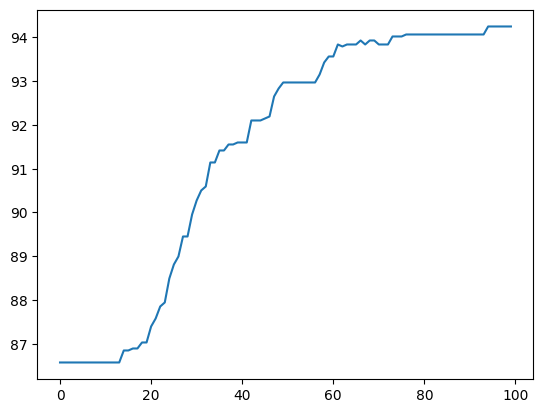

In [20]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = model.to(my_device)

epochs = 100
lr = 1e-3
dataset = 'SoyNet'
prefix = 'MobileNet-FT-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# treina o modelo
net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 1886
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
0
Predicted: Disease | Corrected: Disease | Confidence: 99.92%


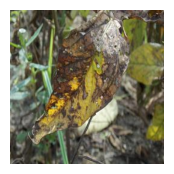

In [21]:
import numpy as np
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    my_transform = MobileNet_V2_Weights.DEFAULT.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = ["Disease", "Healthy"]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
